# Transfer learning on the Caltech101 dataset

In this notebook, we will consider a more complex dataset than MNIST or CIFAR10. The images in Caltech101 are RGB images (3 channels) with variable size. There are 101 different classes. We will try a very common practice in computer vision nowadays: transfer learning from a pre-trained ImageNet model. 

Roadmap:
- Modify the network from the previous exercise (CIFAR-10) to work with 224x224 images.
- Train the model for a while on Caltech101 and see how far we can get.
- Take a ResNet34 that was pre-trained on ImageNet-1k and fine-tune it to Caltech101.
  - Consider both training only the head (the linear classifier at the end of the network) or the entire network.
  - We should be able to reach better performance than our original network in fewer training steps.
- Optional: play around with other pre-trained models from `timm` (see info [here](https://github.com/rwightman/pytorch-image-models)).


## Preliminaries

In [1]:
%matplotlib inline
from typing import List, Optional, Callable, Iterator
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, Dataset, Subset

sns.set_style("whitegrid")

!pip install timm
import timm

def accuracy(target, pred):
    return accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def show_image(img, title=None):
    img = img.detach().cpu()
    img = img.permute((1, 2, 0)).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean   # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.gca().tick_params(axis="both", which="both", bottom=False, left=False, labelbottom=False, labelleft=False)
    if title is not None:
        plt.title(title)

  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.5.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached certifi-2025.8.3-py3-none-any.whl.metadata (2.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 31.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 563.4/563.4 kB 23.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 33.3 MB/s  0:00:00
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Using cached requests-2.32.5-py3-none-any.whl (64 kB)
Using cached idna-3.10-py3-none-any.whl (70 kB)
Using cached urllib3-2.5.0-py3-none-any.whl (129 kB)
Using cached certifi-2025.8.3-py3-none-any.whl (161 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11/11 [timm]2m10/11 [timm]ngface_hub]


/Users/vincent/anaconda3/envs/DTU_deep-learning/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Set up dataset

In [5]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
default_imagenet_normalization = transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.25, 1)),  # crop of random size and aspect ratio, resize to square
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    default_imagenet_normalization,
])
test_transform = transforms.Compose([
    transforms.Resize(224),  # keep aspect ratio
    transforms.CenterCrop(224),  # square crop
    transforms.ToTensor(),
    default_imagenet_normalization,
])

batch_size = 64  # both for training and testing

# If automatic download fails, download manually from:
# https://data.caltech.edu/records/mzrjq-6wc02/files/caltech101.zip?download=1
# Unzip to './data' so that './data/101_ObjectCategories' exists.

try:
    dataset = torchvision.datasets.Caltech101(root='./data', download=True)
except Exception as e:
    print("Automatic download failed. Please download manually from:")
    print("https://data.caltech.edu/records/mzrjq-6wc02/files/caltech101.zip?download=1")
    print("Unzip to './data' so that './data/101_ObjectCategories' exists.")
    # Try loading without download
    dataset = torchvision.datasets.Caltech101(root='./data', download=False)


def translate_label(y, keep_classes):
    try:
        return keep_classes.index(y)
    except ValueError:
        return -1


# Filter images such that no class has more than 100 examples.
# Loop through dataset in random order, include each image (its index) only if there are 
# fewer than 100 images of the same class.
# Here we also remove the classes "Faces" and "Faces_easy".
skip_classes = [0, 1]   # "Faces" and "Faces_easy"
keep_classes = [c for c in range(len(dataset.categories)) if c not in skip_classes]
indices = list(range(len(dataset)))
random.shuffle(indices)
new_indices = []
current_class_size = {class_number: 0 for class_number in np.unique(dataset.y)}
for i in indices:
    class_number = dataset.y[i]
    if class_number not in skip_classes and current_class_size[class_number] < 100:
        new_indices.append(i)
        current_class_size[class_number] += 1
indices = new_indices

# Compute subset of labels given new indices selection
labels = [translate_label(dataset.y[i], keep_classes) for i in indices]
assert max(labels) == 98

test_size = 640
train_size = len(indices) - test_size
train_idx, test_idx = train_test_split(
    indices,
    train_size=train_size,
    test_size=test_size,
    shuffle=True,
    random_state=42,  # always get the same split
    stratify=labels,
)


class DatasetSubsetWithTransform(Subset):
    
    def __init__(self, dataset, indices, transform=None):
        super().__init__(dataset, indices)
        self.transform = transform

    def _transform_and_translate(self, x, y):
        # Convert PIL image to RGB (some of them are greyscale)
        x = x.convert('RGB')
        if self.transform is not None:
            x = self.transform(x)
        y = translate_label(y, keep_classes)
        return x, y

    def __getitem__(self, idx):
        return self._transform_and_translate(*super().__getitem__(idx))
    
    def __getitems__(self, indices):
        items = super().__getitems__(indices)
        for i in range(len(items)):
            items[i] = self._transform_and_translate(*items[i])
        return items


train_set = DatasetSubsetWithTransform(dataset, train_idx, train_transform)
test_set = DatasetSubsetWithTransform(dataset, test_idx, test_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=False)

### A closer look at the dataset

We first plot the size of each class and observe the class distribution is not uniform.

Then we show random examples from the dataset, annotated with the class label and index.
Note that the training images include standard augmentations typically used for vision models (defined above).

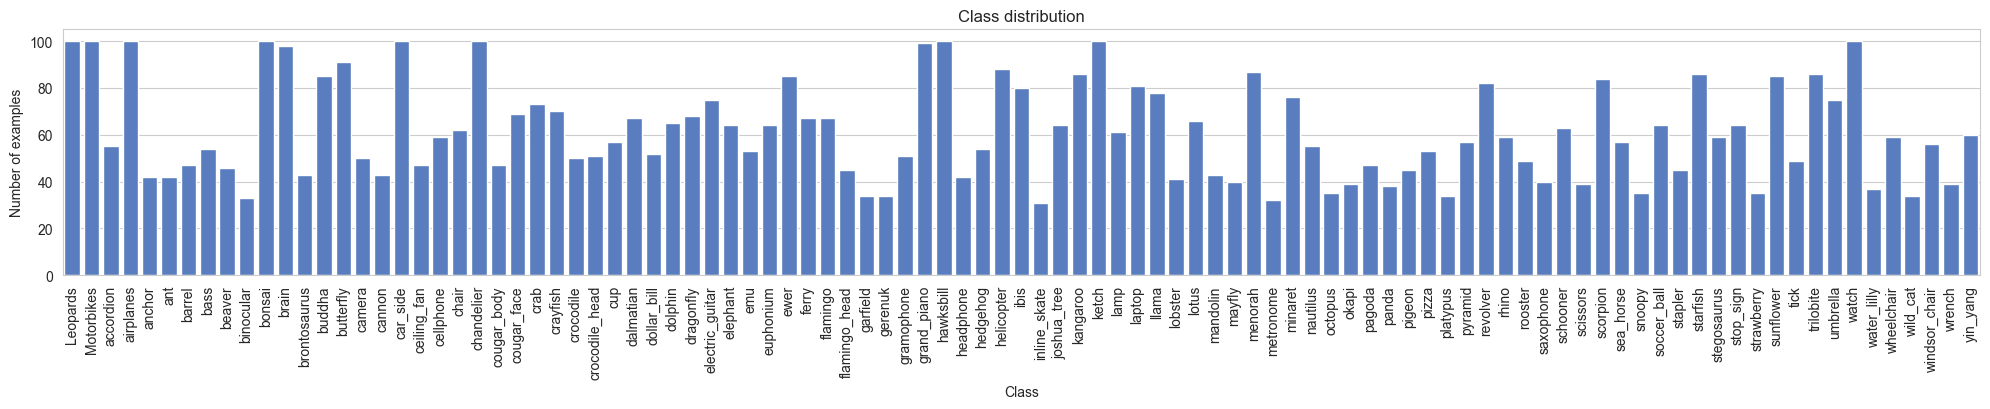



Train images (including augmentations):


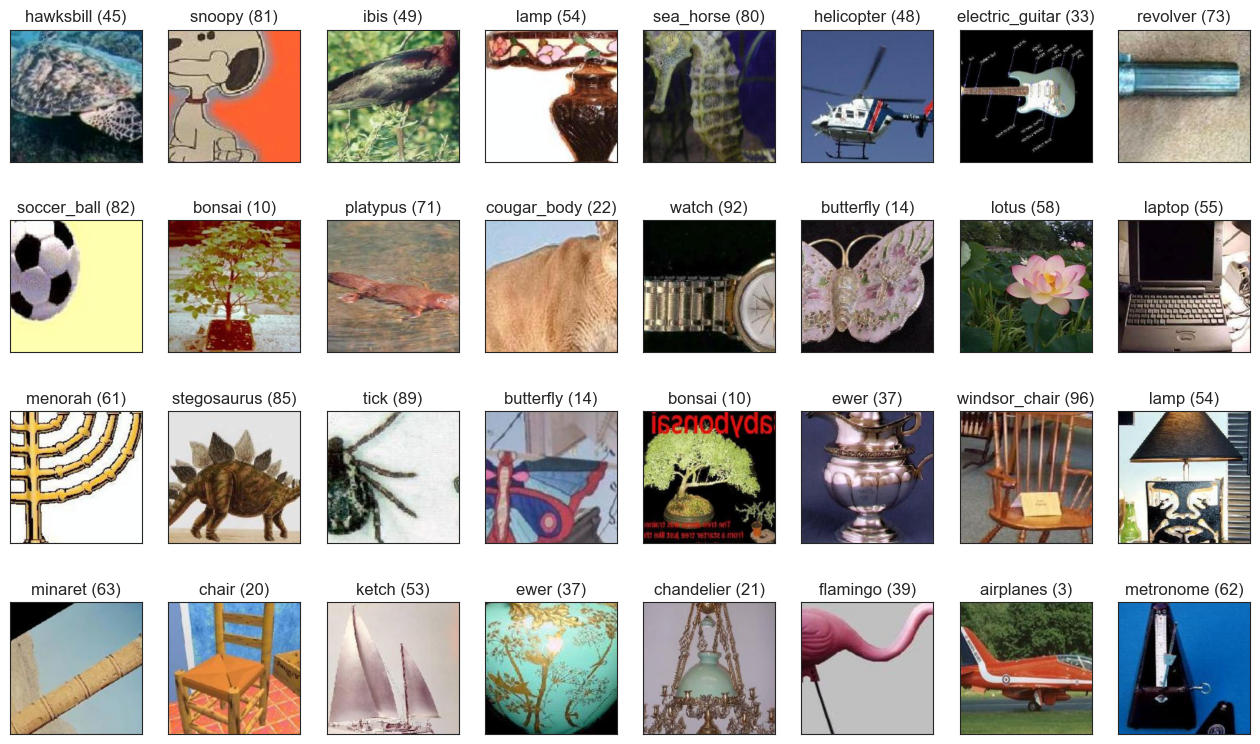



Test images:


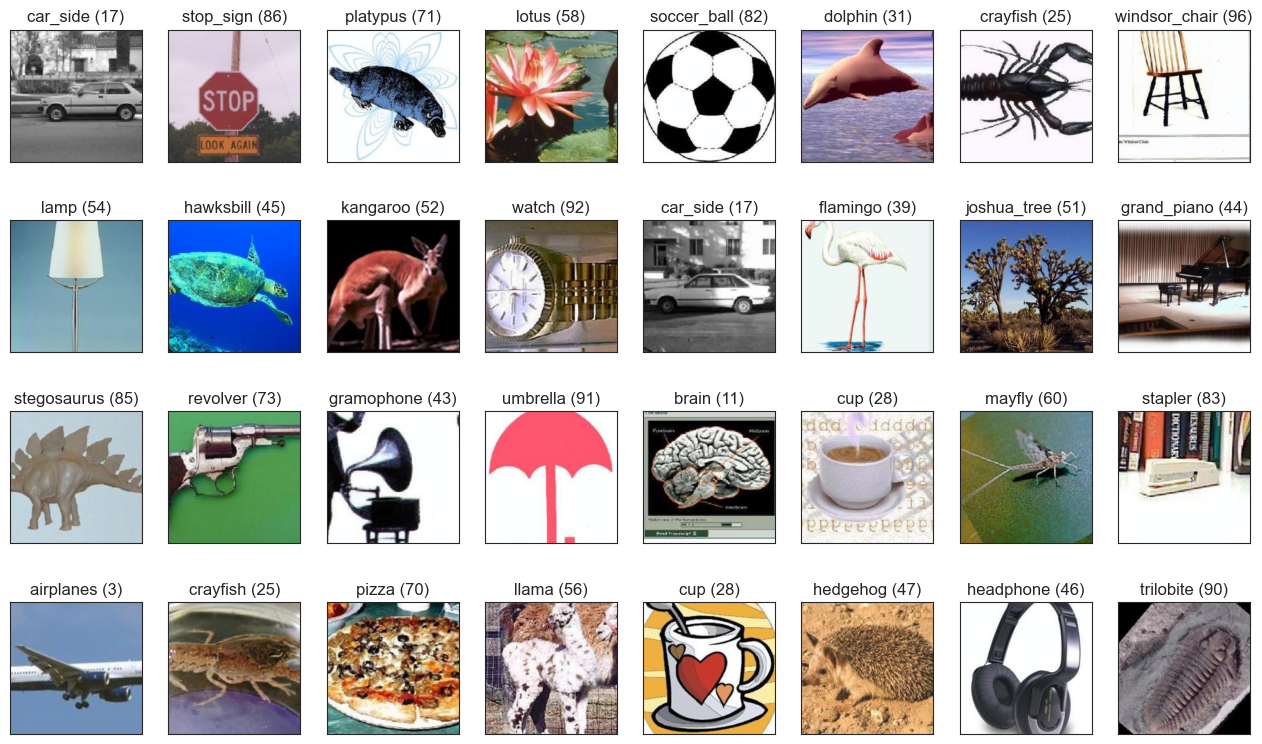

In [6]:
label_idxs, counts = np.unique(labels, return_counts=True)
plt.figure(figsize=(20, 4.2))
sns.barplot(x=[dataset.categories[keep_classes[label]] for label in label_idxs], y=counts, color=sns.color_palette('muted')[0])
plt.xticks(rotation=90)
plt.xlabel("Class")
plt.ylabel("Number of examples")
plt.title("Class distribution")
plt.tight_layout()
plt.show()


def show_dataset_examples(dataloader):
    images, labels = next(iter(dataloader))
    with sns.axes_style("white"):
      fig, axes = plt.subplots(4, 8, figsize=(16, 9.5))
    axes = [ax for axes_ in axes for ax in axes_]   # flatten
    for j, (img, label) in enumerate(zip(images[:32], labels[:32])):
        plt.sca(axes[j])
        show_image(img, title=f"{dataset.categories[keep_classes[label.item()]]} ({label.item()})")
    plt.show()


print("\n\nTrain images (including augmentations):")
show_dataset_examples(train_loader)
print("\n\nTest images:")
show_dataset_examples(test_loader)

## Define a neural network

**Assignment 1:** Adapt the CNN from the previous lab (CIFAR-10) to handle 224x224 images. We recommend reducing significantly the size of the tensors before flattening, by adding either convolutional layers with stride>1 or [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) layers (but see e.g. also [AvgPool2d](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html)).

In [ ]:
class Model(nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        
        self.net = ...   # Your code here!

    def forward(self, x):
        return self.net(x)
    
    
model = Model(num_classes=len(np.unique(labels)))
device = torch.device('cuda')  # use cuda or cpu
model = model.to(device)
print(model)

## Define loss function and optimizer

**Assignment 2:** Implement the criterion and optimizer, as in the previous notebook.

In [ ]:
loss_fn = None  # Your code here!
optimizer = None  # Your code here!

## Train the network

In [ ]:
# Test the forward pass with dummy data
out = model(torch.randn(2, 3, 224, 224).to(device))
print("Output shape:", out.size())

In [ ]:
num_epochs = 10
validation_every_steps = 50

step = 0
model.train()

train_accuracies = []
valid_accuracies = []
        
for epoch in range(num_epochs):
    
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass.
        output = model(inputs)
        
        # Compute loss.
        loss = loss_fn(output, targets)
        
        # Clean up gradients from the model.
        optimizer.zero_grad()
        
        # Compute gradients based on the loss from the current batch (backpropagation).
        loss.backward()
        
        # Take one optimizer step using the gradients computed in the previous step.
        optimizer.step()
        
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")

print("Finished training.")

## Test the network on the test data


In [ ]:
# Evaluate test set
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    print(f"Test accuracy: {test_accuracy:.3f}")
    
    model.train()


## Using a pre-trained model


---
Here we will load a ResNet34 that was pre-trained on ImageNet. We then 
- discard the linear classifier at the end of the network (the "head" of the network)
- replace it with a new one that outputs the desired number of logits for classification. 
---

The argument `finetune_entire_model` in `initialize_model()` controls whether the entire pre-trained model is fine-tuned. 
- When this is `False`, **only the linear head is trained**, and the rest of the model is fixed. 

---

The idea is that the **features extracted by the ImageNet model, up to the final classification layer, are very informative also on other datasets** 

---

We will start here by training only the linear head. You can experiment different models and variations.

Below, we define the model and forget the one we just trained. After that, you can go back to the section "Define loss function and optimizer" and re-execute the notebook from there, to train and evaluate the new model.


In [12]:
def initialize_model(model_name: str, *, num_classes: int, finetune_entire_model: bool = False):
    """Returns a pretrained model with a new last layer, and a dict with additional info.

    The dict now contains the number of model parameters, computed as the number of
    trainable parameters as soon as the model is loaded.
    """

    print(
        f"Loading model '{model_name}', with "
        f"finetune_entire_model={finetune_entire_model}, changing the "
        f"last layer to output {num_classes} logits."
    )
    model = timm.create_model(
        model_name, pretrained=True, num_classes=num_classes
    )

    num_model_parameters = 0
    for p in model.parameters():
        if p.requires_grad:
            num_model_parameters += p.numel()

    if not finetune_entire_model:
        for name, param in model.named_parameters():
            param.requires_grad = False

        # Layer names are not consistent, so we have to consider a few cases. This might 
        # break for arbitrary models from timm (we have not checked all available models).
        layer = None
        if hasattr(model, "classifier"):
            if isinstance(model.classifier, nn.Linear):
                layer = model.classifier
        elif hasattr(model, "head"):
            if isinstance(model.head, nn.Linear):
                layer = model.head
            elif hasattr(model.head, "fc") and isinstance(model.head.fc, nn.Linear):
                layer = model.head.fc
            elif hasattr(model.head, "l") and isinstance(model.head.l, nn.Linear):
                layer = model.head.l
        elif hasattr(model, "fc"):
            if isinstance(model.fc, nn.Linear):
                layer = model.fc
        if layer is None:
            raise ValueError(f"Couldn't automatically find last layer of model.")
        
        # Make the last layer trainable.
        layer.weight.requires_grad_()
        layer.bias.requires_grad_()

    num_trainable_model_parameters = 0
    for p in model.parameters():
        if p.requires_grad:
            num_trainable_model_parameters += p.numel()

    return model, {
        "num_model_parameters": num_model_parameters,
        "num_trainable_model_parameters": num_trainable_model_parameters,
    }

# Returns a pretrained model with a new last layer, 
# and a dict with additional info.
# -> data contains: 
#    - num_model_parameters: total number of parameters in the model
#    - num_trainable_model_parameters: number of parameters that are trainable
#
# -> first argument:    the model architecture
# -> second argument:   the number of output classes
model, data = initialize_model('resnet34d', num_classes=len(np.unique(labels)), finetune_entire_model=False)

# Now we can modify the last (newly added) layer if we want to.
# For example, we can replace it with a small feedforward network.

print(model)

# We see that this a ResNet model.
#
# This is just a naming convention, we can define our own as well:
#
#   class ResNetOwn(nn.Module):
#       ...
#
# We add a ResNetBlock to the ResNetOwn, in which
# the forward method has in its forward function
#
#   def forward(self, x):
#       identity = x
#       ...
#       out += identity
#       out = self.activation(out)
#       return out

# -> Last layer is model.fc
# -> We can replace it with a small feedforward network, for example:
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Linear(256, len(np.unique(labels))),
)

print("Number of model parameters:", data["num_model_parameters"])
print("Number of trainable parameters:", data["num_trainable_model_parameters"])

device = torch.device('cpu')  # use cuda or cpu
model = model.to(device)


Loading model 'resnet34d', with finetune_entire_model=False, changing the last layer to output 99 logits.
ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNor

**Assignment 3:** 

1. Train the linear classifier on top of the pre-trained network, and observe how quickly you can get pretty good results, compared to training a smaller network from scratch as above.

2. Go back and change argument to finetune entire network, maybe adjust learning rate, see if you can get better performance than before and if you run into any issues.

3. Optional: experiment with `timm`: try smaller or larger models, including state-of-the-art models, e.g. based on vision transformers (ViT) or MLP-Mixers.

4. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?

5. Write down key lessons/insights you got during this exercise.


In [14]:
# Train the linear classifier on top of the pretrained model.

loss_fn = nn.CrossEntropyLoss() # does softmax internally
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10
validation_every_steps = 50

step = 0
model.train()

train_accuracies = []
valid_accuracies = []
        
for epoch in range(num_epochs):
    
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass.
        output = model(inputs)
        
        # Compute loss.
        loss = loss_fn(output, targets)
        
        # Clean up gradients from the model.
        optimizer.zero_grad()
        
        # Compute gradients based on the loss from the current batch (backpropagation).
        loss.backward()
        
        # Take one optimizer step using the gradients computed in the previous step.
        optimizer.step()
        
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")

print("Finished training.")


/Users/vincent/anaconda3/envs/DTU_deep-learning/lib/python3.13/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
/Users/vincent/anaconda3/envs/DTU_deep-learning/lib/python3.13/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
/Users/vincent/anaconda3/envs/DTU_deep-learning/lib/python3.13/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true"

Step 50      training accuracy: 0.2984375
             test accuracy: 0.6140625


/Users/vincent/anaconda3/envs/DTU_deep-learning/lib/python3.13/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
/Users/vincent/anaconda3/envs/DTU_deep-learning/lib/python3.13/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
/Users/vincent/anaconda3/envs/DTU_deep-learning/lib/python3.13/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true"

KeyboardInterrupt: 